In [1]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [2]:
!nvidia-smi

Tue Mar  2 22:02:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 32%   31C    P2    62W / 250W |    158MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
print(tf.autograph.to_code(model_zoo._pairwise_add.python_function))

def tf___pairwise_add(X_split, num_channels, source_axis, mode, aggregation):
    do_return = False
    retval_ = ag__.UndefinedReturnValue()
    with ag__.FunctionScope('_pairwise_add', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        print('Tracing')
        ag__.converted_call(tf.print, ('executing',), None, fscope)
        max_pairwise_similarity = ag__.converted_call(tf.TensorArray, (), dict(dtype=tf.float32, size=(num_channels - 1)), fscope)

        def get_state_5():
            return (max_pairwise_similarity,)

        def set_state_5(loop_vars):
            nonlocal max_pairwise_similarity
            (max_pairwise_similarity,) = loop_vars

        def loop_body(itr):
            nonlocal max_pairwise_similarity
            k = itr

            def get_state_1():
                return ()

            def set_state_1(loop_vars):
                pass

            def if_true_1():
 

In [3]:
!pip install mne
!pip install tensorflow-addons
!pip install scikit-learn
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def run_and_save(line, cell):
    'Run and save python code block to a file'
    with open(line, 'wt') as fd:
        fd.write(cell)
    code = compile(cell, line, 'exec')
    exec(code, globals())

In [5]:
import os
try:
    networkname="../results/correlation1"
    os.makedirs(networkname)
except:
    print('Exists')

In [6]:
%%run_and_save {networkname}/config.py

import matplotlib
from libs import GeneratorCNN
matplotlib.interactive(False)
from importlib import reload
import gc
from libs import model_zoo
import BaseLineModel as approach
import numpy as np
from importlib import reload
from libs import utils
from libs.utils import Bunch
from libs import Multi_Class_Metrics as mcm
from tensorflow.keras import callbacks

reload(utils)
reload(GeneratorCNN)
reload(model_zoo)
network = model_zoo.ConnectivityModel#EEGNetLawhern#ConnectivityModel#SpatialTemporalMultiClass#ConnectivityModel#Channel_Decision_Small#Channel_Decision_Model#ShallowConvNetMultiClass#SpatialTemporalMultiClass#ShallowConvNetMultiClassLinear##SpatialAverageModel# ConnectivityModel#
gc.collect()
use_stable=True
subjects = {'dementia':[],'control':[],'mci':[]}
utils.get_subjects_wrt_site(subjects,30,30,'dementia')
utils.get_subjects_wrt_site(subjects,100,100,'control')
utils.get_subjects_wrt_site(subjects,1,15,'mci')
subjects['dementia'].remove(27)

use_stable='all'
if use_stable=='order0':
    channel_matches = np.load('pareto_opt_matches.npy')
    channel_matches = utils.get_stable_channels(channel_matches,0).T#[:,44:46]
elif use_stable=='all':
    import json
    with open('A_B_bestpositional_hungarian.json') as f:
        match = json.load(f)
    match['matching0'].pop('info')
    channel_matches = np.array([list(match['matching0'].keys()),list(match['matching0'].values())]).astype(int)
elif use_stable is None:
    channel_matches = np.stack([np.arange(160),np.arange(160)])

site_as_label = False
if site_as_label:
    num_classes = 2
else:
    num_classes = 3


sensitivity_mci_dem = mcm.MultiClassRecall(num_classes=num_classes,
                                           pos_ind=[1,2],
                                           average='macro',
                                           name="mci_dem_sensitivity")
specificity_mci_dem = mcm.MultiClassSpecificity(num_classes=num_classes,
                                                pos_ind=[1,2],
                                                average='macro',
                                                name="mci_dem_Specificity")
f1_mci_dem = mcm.MultiClassF1(num_classes=num_classes,
                              pos_ind=[1,2],average='macro',
                              name="mci_dem_F1")
metrics = ['acc', sensitivity_mci_dem, specificity_mci_dem,f1_mci_dem]


callbacks = [callbacks.EarlyStopping(patience=5,
                                     restore_best_weights=True,
                                     monitor="val_mci_dem_F1",
                                     mode='max',
                                     verbose=1)]
frame_size = utils.Bunch(value=2,unit='s')
fs = 256
network_params = {
    'batch_size':8,
    'use_bn':True,
    'do_ratio':0.2,
    'numTrainEpochs':15,
    'optimizer':'adam',
    'frame_size':frame_size,
    'cross_subjects':True,
    'num_classes':num_classes,
    'n_folds':5,
    'use_class_weights':True,
    'workers':8,
    'multiprocessing':False,
    'monitor':"val_mci_dem_F1"
    }

data_params={
             'standardize':'em_astd',#'ema',#'look_at_time',# look_at_time
             'fs':fs,
             'channel_matches':channel_matches,
             'subjects':subjects,
             'test_ratio':0.2,
             'readSubjects_params':{
                 'site_as_label':site_as_label,
                 'l_freq':1,
                 'h_freq':14,
                 'frame_length':utils.time2samples(time_container=frame_size,fs=fs),
                 'bad_samples_path':r'../cache/bad_samples'
                 },
            }
# the first 80 magnetic poles contain the inner magnetic field
SA  = np.load('SA.npy')[:,:80]
SB  = np.load('SB.npy')[:,:80]
pSA = np.load('pSA.npy')[:80]
pSB = np.load('pSB.npy')[:80]

# Build augmentation pipeline for Generator
function_params = {}
function_params['draw_random_time_frame']={
   'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
   'trial_length':5*60*data_params['fs']}
function_params['additive_correlated_noise']={'sigma_noise':5e-2}
function_params['transform_recording_site']={'sensor_inv':[pSA,pSB],
                                             'sensor_fwd':[SA,SB],
                                             'map_to':'random'}
function_params['apply_channel_matches']={'matches':data_params['channel_matches']}

functions=[GeneratorCNN.draw_random_time_frame,
           GeneratorCNN.additive_correlated_noise,
           GeneratorCNN.transform_recording_site,
           GeneratorCNN.apply_channel_matches
           ]

prob = {'apply_channel_matches':1.0,
        'draw_random_time_frame':1.0,
        'transform_recording_site':1.0,
        'additive_correlated_noise':0.5,
        }

train_aug_pipe=GeneratorCNN.Augment_Pipeline(functions=functions,
                                  params=function_params,
                                  p=prob)
func = [
        GeneratorCNN.draw_random_time_frame,
        GeneratorCNN.transform_recording_site,
        GeneratorCNN.apply_channel_matches]
p = {'transform_recording_site':1,'apply_channel_matches':1,'draw_random_time_frame':1}
aug_params = {
    'transform_recording_site':
       {'map_to':'identity',
        'sensor_inv':[pSA,pSB],
        'sensor_fwd':[SA,SB]},
    'apply_channel_matches':
        {'matches':data_params['channel_matches']},
    'draw_random_time_frame':
        {'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
        'trial_length':5*60*data_params['fs']}
        }
valid_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)

r
calc scores updata
r


/tf/TeleBrain/Biomag21/libs/utils.py:382: UserWarning: Method is deprecated us 'get_site'.
  warnings.warn("Method is deprecated us 'get_site'.")


reload(mcm)
reload(GeneratorCNN)
reload(approach.GeneratorCNN)
reload(utils)
reload(model_zoo)
reload(approach)
reload(approach.readSubjects)

In [7]:
reload(approach)

trainer = approach.RunTraining(dataDir=r'../cache/raw',
                               train_path_info='./info',
                               static_data_params=data_params,
                               network_params=network_params,
                               completeDir=networkname)

In [ ]:
last_model = trainer.start_main(network=network,
                                train_augment_pipeline=train_aug_pipe,
                                valid_augment_pipeline=valid_pipe,
                                metrics=metrics,
                                callbacks_list=callbacks)


#########
{'mci': 12, 'dementia': 22, 'control': 79}


/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
  0%|          | 0/113 [00:00<?, ?it/s]

/tf/TeleBrain/Biomag21/libs/utils.py:382: UserWarning: Method is deprecated us 'get_site'.
  warnings.warn("Method is deprecated us 'get_site'.")
100%|██████████| 113/113 [01:19<00:00,  1.42it/s]


Network has shape:  (512, 160, 1)
2
Tracing
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 160, 16)      576       
_________________________________________________________________
average_pooling2d (AveragePo (None, 256, 160, 16)      0         
_________________________________________________________________
pairwise_channel_add (Pairwi (None, 256, 159, 16)      0         
_________________________________________________________________
spatial_conv (Conv2D)        (None, 256, 1, 16)        40720     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 1, 16)        64        
_________________________________________________________________
activation (Activ

/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Exponential moving z score with alpha: 0.0005
Train Patients: 
 ['control18' 'control19' 'control20' 'control26' 'control27' 'control28'
 'control29' 'control30' 'control31' 'control33' 'control34' 'control35'
 'control36' 'control37' 'control38' 'control39' 'control40' 'control41'
 'control42' 'control43' 'control44' 'control45' 'control46' 'control47'
 'control48' 'control49' 'control50' 'control51' 'control52' 'control54'
 'control55' 'control56' 'control57' 'control58' 'control59' 'control61'
 'control62' 'control63' 'control64' 'control66' 'control67' 'control68'
 'control69' 'control70' 'control71' 'control72' 'control73' 'control74'
 'control75' 'control76' 'control77' 'control79' 'control80' 'control81'
 'control82' 'control83' 'control84' 'control85' 'control86' 'control87'
 'control88' 'control89' 'control90' 'control91' 'control92' 'control93'
 'control94' 'control96' 'control97' 'control98' 'control99' 'dementia11'
 'dementia13' 'dementia14' 'dementia15' 'dementia16' 'demen

/tf/TeleBrain/Biomag21/libs/GeneratorCNN.py:489: UserWarning: Make sure that the recording site is provided for each subject.
  warnings.warn('Make sure that the recording site is provided for each subject.')


Epoch 1/15
2
2
1893/1893 [==============================] - ETA: 0s - loss: 0.6508 - acc: 0.7130 - mci_dem_sensitivity: 0.7128 - mci_dem_Specificity: 0.9411 - mci_dem_F1: 0.55032
2
2
2
2
2
2
2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../results/correlation1/cp.ckpt/assets
1893/1893 [==============================] - 764s 404ms/step - loss: 0.6508 - acc: 0.7130 - mci_dem_sensitivity: 0.7128 - mci_dem_Specificity: 0.9411 - mci_dem_F1: 0.5503 - val_loss: 1.8693 - val_acc: 0.3172 - val_mci_dem_sensitivity: 0.4536 - val_mci_dem_Specificity: 0.8645 - val_mci_dem_F1: 0.1418
Epoch 2/15
1893/1893 [==============================] - ETA: 0s - loss: 0.4345 - acc: 0.8230 - mci_dem_sensitivity: 0.8270 - mci_dem_Specificity: 0.9650 - mci_dem_F1: 0.70232
2
2
2
2
2
2
INFO:tensorflow:Assets written to: ../results/correlation1/cp.ckpt/assets
1893/1893 [==============================] - 549s 290ms/step - loss: 0.4345 - acc: 0.8230 

In [9]:

for fold in np.arange(1,5,1):
    last_model = trainer.continue_training(fold,network,metrics=metrics,
                                           callbacks_list=callbacks)
    results = trainer.test_model(model,test_pipe,fold=fold,keep_data=True, 
                                 data_loaded=False,iterative=False)
    conf_mat = trainer.evaluate3classes(results[0],results[1],fold=fold,metrics=metrics[1:])
    results_features_test = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=True,
                                                 subject_group='test_subjects.json',
                                                 iterative=False,
                                                 make_classification=False)
    results_features_train = trainer.test_model(feature_model,test_pipe,fold,
                                                 keep_data=False,data_loaded=False,
                                                 subject_group='train_subjects.json',
                                                iterative=True,
                                                make_classification=False)


{'mci': 12, 'dementia': 22, 'control': 79}


  0%|          | 0/113 [00:00<?, ?it/s]

100%|██████████| 113/113 [01:19<00:00,  1.41it/s]


Network has shape:  (512, 160, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 160, 1)]     0         
_________________________________________________________________
permute (Permute)            (None, 160, 512, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 512, 8)       512       
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 512, 8)       32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 512, 16)        2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 512, 16)        64        
_________________________________________________________________
activation (Activation)    

/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


class_weights: 
 {0: 0.4767932489451477, 1: 3.138888888888889, 2: 1.7121212121212122}
num splits:  10
Exponential moving z score with alpha: 0.0005
Exponential moving z score with alpha: 0.0005
Train Patients: 
 ['control100' 'control18' 'control19' 'control20' 'control23' 'control26'
 'control27' 'control28' 'control29' 'control30' 'control31' 'control32'
 'control33' 'control34' 'control35' 'control36' 'control37' 'control38'
 'control39' 'control40' 'control42' 'control43' 'control44' 'control45'
 'control46' 'control47' 'control48' 'control49' 'control50' 'control51'
 'control52' 'control53' 'control54' 'control55' 'control56' 'control57'
 'control58' 'control60' 'control61' 'control63' 'control65' 'control66'
 'control67' 'control69' 'control70' 'control71' 'control72' 'control73'
 'control74' 'control75' 'control76' 'control77' 'control78' 'control79'
 'control80' 'control81' 'control82' 'control83' 'control85' 'control86'
 'control87' 'control88' 'control90' 'control91' 'control

/tf/TeleBrain/Biomag21/libs/GeneratorCNN.py:489: UserWarning: Make sure that the recording site is provided for each subject.
  warnings.warn('Make sure that the recording site is provided for each subject.')


Epoch 1/15
 641/1893 [=========>....................] - ETA: 11:06 - loss: 0.9803 - acc: 0.5137 - mci_dem_sensitivity: 0.4488 - mci_dem_Specificity: 0.8860 - mci_dem_F1: 0.2660

KeyboardInterrupt: 

In [15]:
reload(GeneratorCNN)
reload(approach.GeneratorCNN)
fold=0
overlap = 256
func = [
        GeneratorCNN.draw_continuous_time_frame,
        GeneratorCNN.transform_recording_site,
        GeneratorCNN.apply_channel_matches]
p = {'transform_recording_site':1,'apply_channel_matches':1,'draw_continuous_time_frame':1}
aug_params = {
    'transform_recording_site':
       {'map_to':'identity',
        'sensor_inv':[pSA,pSB],
        'sensor_fwd':[SA,SB]},
    'apply_channel_matches':
        {'matches':data_params['channel_matches']},
    'draw_continuous_time_frame':
        {'frame_length':utils.time2samples(fs=data_params['fs'],time_container=network_params['frame_size']),
        #'trial_length':5*60*data_params['fs']
         'overlap':overlap
         }
        }
test_pipe = GeneratorCNN.Augment_Pipeline(func,aug_params,p)
test_pipe.params['overlap']=overlap

model = trainer.load_model(fold)
from tensorflow.keras import models
feature_model = models.Model(model.input,model.layers[-3].output)


In [16]:
results = trainer.test_model(model,test_pipe,fold=fold,keep_data=True, 
                             data_loaded=False,iterative=False)
conf_mat = trainer.evaluate3classes(results[0],results[1],fold=fold,metrics=metrics[1:])
results_features_test = trainer.test_model(feature_model,test_pipe,fold,
                                             keep_data=False,data_loaded=True,
                                             subject_group='test_subjects.json',
                                             iterative=False,
                                             make_classification=False)
results_features_train = trainer.test_model(feature_model,test_pipe,fold,
                                             keep_data=False,data_loaded=False,
                                             subject_group='train_subjects.json',
                                            iterative=True,
                                            make_classification=False)


/content/drive/My Drive/biomag21/libs/GeneratorCNN.py:489: UserWarning: Make sure that the recording site is provided for each subject.
  warnings.warn('Make sure that the recording site is provided for each subject.')


{'mci': 3, 'dementia': 6, 'control': 21}


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


Exponential moving z score with alpha: 0.0005


100%|██████████| 30/30 [01:19<00:00,  2.66s/it]


| ids         |   y |   pred | site   |
|:------------|----:|-------:|:-------|
| control002  |   0 |      0 | B      |
| control003  |   0 |      0 | A      |
| control005  |   0 |      2 | A      |
| control006  |   0 |      0 | A      |
| control007  |   0 |      0 | A      |
| control008  |   0 |      1 | B      |
| control009  |   0 |      1 | B      |
| control010  |   0 |      1 | B      |
| control011  |   0 |      0 | A      |
| control012  |   0 |      0 | A      |
| control013  |   0 |      0 | A      |
| control014  |   0 |      1 | B      |
| control015  |   0 |      0 | A      |
| control016  |   0 |      2 | A      |
| control017  |   0 |      1 | B      |
| control021  |   0 |      0 | A      |
| control022  |   0 |      0 | A      |
| control024  |   0 |      0 | A      |
| control025  |   0 |      0 | A      |
| control001  |   0 |      0 | A      |
| control004  |   0 |      0 | A      |
| dementia001 |   2 |      0 | A      |
| dementia002 |   2 |      1 | B      |


  0%|          | 0/30 [00:00<?, ?it/s]

mci_dem_Specificity : tf.Tensor(0.9583334, shape=(), dtype=float32)
mci_dem_F1 : tf.Tensor(0.5833334, shape=(), dtype=float32)


  0%|          | 0/1 [00:00<?, ?it/s]

Feature output
{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 0, 'control': 1}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 1, 'dementia': 0, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



  0%|          | 0/1 [00:00<?, ?it/s]

{'mci': 0, 'dementia': 1, 'control': 0}



100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


Feature output


In [ ]:
results[1].shape

(30, 128, 3)

{'mci': 4, 'dementia': 5, 'control': 20}
[{'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol035raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol040raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol045raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol046raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol047raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


Exponential moving z score with alpha: 0.0005


/content/drive/MyDrive/biomag21/libs/GeneratorCNN.py:468: UserWarning: Make sure that the recording site is provided for each subject.
  warnings.warn('Make sure that the recording site is provided for each subject.')


Missclassified subjects:  ['control35' 'control40' 'control45' 'control46' 'control47' 'control48'
 'control49' 'control50' 'control51' 'control52' 'control53' 'control54'
 'control55' 'control56' 'control57' 'control58' 'control59' 'control60'
 'control61' 'control77' 'dementia8' 'dementia9' 'dementia16' 'dementia17'
 'dementia18' 'mci6' 'mci7' 'mci8' 'mci11']
Todo: Wrap into method


<Figure size 432x288 with 0 Axes>

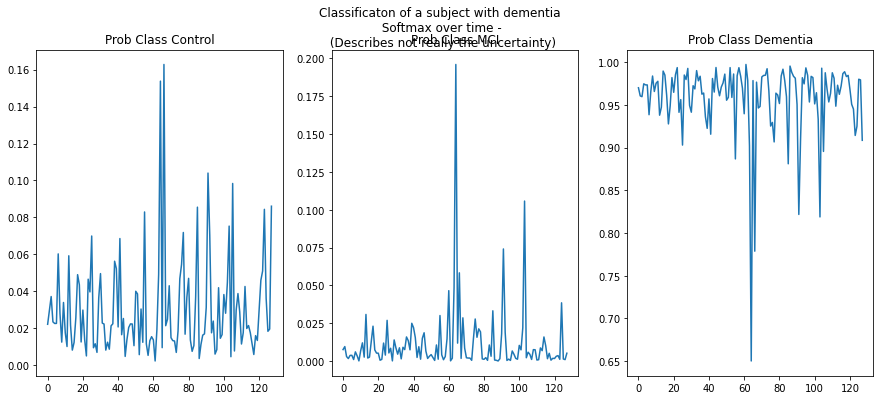

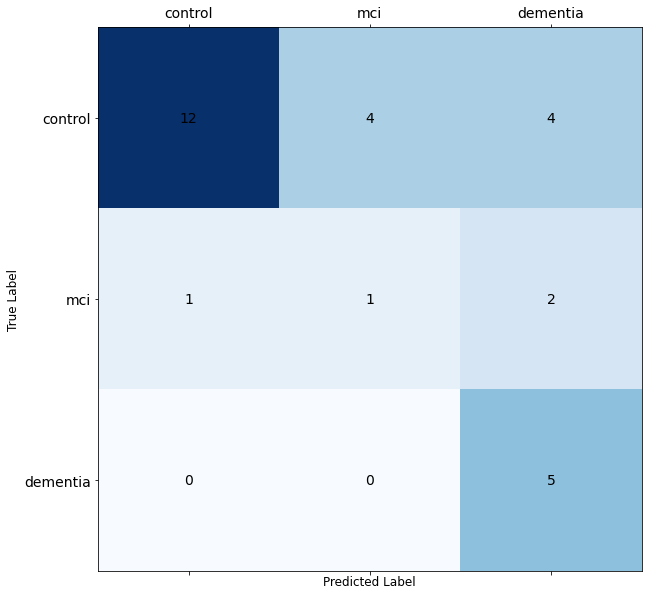

Cohen's Kappa:  0.3695652


In [ ]:

results = trainer.test_model(last_model,valid_pipe,fold=4)


In [ ]:
last_model = trainer.continue_training(2,network)

Model folder already exists. Do you want to continue? Y,NY
{'mci': 11, 'dementia': 24, 'control': 80}
[{'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol002raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol003raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol005raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol006raw.fif'}, {'bad_samples_path': '../BioMagData/badsamples1000Hz', 'frame_length': 512, 'h_freq': 30, 'l_freq': 1, 'site_as_label': False, 'fs': 256, 'file': '100Hzcontrol007raw.fif'}, {'bad_samples_path': '../BioMagD

  0%|          | 0/115 [00:00<?, ?it/s]

 85%|████████▌ | 98/115 [03:15<00:43,  2.56s/it]

In [ ]:
trainer.data=1
trainer.meta=""
results = trainer.test_model(last_model,valid_pipe,fold=2)
conf_mat = approach.evaluate(results[0],results[1])

In [ ]:
batch = valid_pipe(np.expand_dims(trainer.data['X'][idx],axis=0),**{'subject_sites':np.array([site=='B']).astype(int),'target_site':np.array([0])})
p = last_model.predict(batch)
np.mean(p)

0.2901654

In [ ]:
trainer.meta['subjects'][0]

dict_keys(['site', 'condition', 'filename', 'id', 'good_samples'])

In [ ]:
use_stable='all'
if use_stable=='order0':
    channel_matches = np.load('pareto_opt_matches.npy')
    channel_matches = utils.get_stable_channels(channel_matches,0).T#[:,44:46]
elif use_stable=='all':
    import json
    with open('A_B_bestpositional_hungarian.json') as f:
        match = json.load(f)
    match['matching0'].pop('info')
    channel_matches = np.array([list(match['matching0'].keys()),list(match['matching0'].values())]).astype(int)
elif use_stable is None:
    channel_matches = np.stack([np.arange(160),np.arange(160)])
n_frames = 200
all_preds = []
all_labels = []
all_ids = []
for idx in np.random.choice(trainer.valid_index,size=len(trainer.valid_index),replace=False):
  print('\n')
  all_ids+=[trainer.meta['subjects'][k]['id']]
  preds=[]
  t0 =128
  frame_length =256
  site = trainer.meta['subjects'][idx]['site']
  target_site = site
  print('site: ',site)
  print('target: ', target_site)
  print('condition: ',trainer.meta['subjects'][idx]['condition'])
  if site=='A':
    pS = pSA.copy()
  else:
    pS = pSB.copy()

  if target_site=='B':
    S = SB.copy()
  else:
    S = SA.copy()
  time_length = trainer.data['X'].shape[1]
  #for t0 in np.random.choice(np.arange(0,time_length-frame_length),size=n_frames,replace=False):
  #  Xbatch = np.transpose(S@pS@np.transpose(
  #      trainer.data['X'][idx,t0:t0+frame_length,:],[1,0]),[1,0])
  #  Xbatch = Xbatch[:,channel_matches[int(target_site=='B')]]
  #  preds += [np.squeeze(last_model.predict(np.expand_dims(Xbatch,axis=(0,-1))))]
  batch_size=16
  num_batches = 32
  preds = []
  for k in range(num_batches):
      subject_sites = np.array([int(site=='B')]*batch_size)
      target_sites  = np.array([int(target_site=='B')]*batch_size)
      Xbatch = valid_pipe(trainer.data['X'][[idx]*batch_size],**{'subject_sites':subject_sites,
                                                                'target_sites':target_site})
      preds +=[last_model.predict(np.expand_dims(Xbatch,axis=-1))]
  preds = np.concatenate(preds,axis=0)
  all_preds+=[preds]
  all_labels+=[trainer.meta['subjects'][idx]['condition']]
  print(np.mean(preds,axis=0),np.std(preds,axis=0))



site:  A
target:  A
condition:  dementia
[0.09790232 0.04013606 0.8619618 ] [0.14226185 0.0750974  0.16774765]


site:  B
target:  B
condition:  dementia
[0.09894721 0.5866532  0.31439966] [0.16210352 0.28965524 0.26415658]


site:  A
target:  A
condition:  control
[9.8061913e-01 4.7067480e-04 1.8910287e-02] [0.03117673 0.00078347 0.03098592]


site:  A
target:  A
condition:  control
[0.939186   0.00334032 0.0574738 ] [0.13366142 0.0116432  0.1277737 ]


site:  A
target:  A
condition:  control
[0.9781203  0.00245532 0.01942402] [0.0289914  0.00487837 0.02632247]


site:  A
target:  A
condition:  dementia
[0.1523452  0.12952267 0.7181321 ] [0.18556066 0.16062959 0.24728818]


site:  A
target:  A
condition:  control
[9.8752683e-01 6.8174314e-04 1.1791990e-02] [0.02953764 0.00151698 0.02860348]


site:  B
target:  B
condition:  mci
[0.31174624 0.535603   0.15265104] [0.2176814  0.22688401 0.18920921]


site:  A
target:  A
condition:  control
[0.6333063  0.02185703 0.34483668] [0.2880792